# Triggering observation from anb ANTARES locus object with TOM


**This notebook requires the installation of ANTARES client (https://noao.gitlab.io/antares/client/) and TOMtoolkit (https://tom-toolkit.readthedocs.io/en/latest/introduction/getting_started.html#installing-the-tom-toolkit-and-django). For more detail on programmatic access of TOMtoolkit, please see (https://tom-toolkit.readthedocs.io/en/stable/common/scripts.html).**


We can arrange follow up observations of intriguing ANTARES locus/alert using the facilities within the Astronomical Event Observatory Network (AEON). This can be conviently done with the TOMtoolkit as follows.

The first step is to define the target information (name, ra, dec, etc.)

In [1]:
from antares_client.search import get_by_id, get_by_ztf_object_id
#get locus by ANTARES ID
locus = get_by_id("ANT2020bj3s4")

In [2]:
print(locus.locus_id, locus.ra, locus.dec)
print(locus.lightcurve['ant_mag'].iloc[-1], locus.lightcurve['ant_passband'].iloc[-1])

ANT2020bj3s4 227.58436649043028 66.99700788920126
19.123262405395508 R


In [3]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
from tom_targets.models import Target

# Read target from TOM if it already exists, otherwise create a new entry.
try:
    target = Target.objects.get(name=locus.locus_id)
except Exception:
    target = Target.objects.create(name=locus.locus_id, type='SIDEREAL', ra=locus.ra, dec=locus.dec)

The next step is to populate the observation form

In [4]:
from tom_observations.facilities.gemini import GEMFacility, GEMObservationForm

# Obsids of ToO template observations
# These are GMOS longslit science and the associated acquisition
if target.dec < 0.0:
    obsids = ['GS-2019A-TOO-1-2', 'GS-2019A-TOO-1-9']
else:
    obsids = ['GN-2019A-TOO-1-1', 'GN-2019A-TOO-1-11']

# Magnitude system
if locus.lightcurve['ant_passband'].iloc[-1] in ['B', 'V', 'R']:
    magsys = 'Vega'
else:
    magsys = 'AB'
    
form = GEMObservationForm({
    'target_id': target.id,
    'obsid': obsids,
    'ready': 'true',
    'posangle': 180.,
    'exptimes': '1200,60',
    'brightness': str(locus.lightcurve['ant_mag'].iloc[-1]),
    'brightness_band': locus.lightcurve['ant_passband'].iloc[-1],
    'brightness_system': magsys,
    'group': 'ANTARES Triggers',
    'notetitle': 'Note for observer',
    'note': 'A variable star found by ANTARES',
    'window_start': '',
    'eltype': 'none',
    'gstarg': '',
})          

We can check if there is any error of the observation form using form.is_valid()

In [5]:
form.is_valid()

True

Once the form is validated, we can submit it using the following command:

In [6]:
observation_ids = GEMFacility().submit_observation(form.observation_payload())

print(observation_ids) 

/Users/miniconda2/envs/tom_env/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gnodbtest.gemini.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/Users/miniconda2/envs/tom_env/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gnodbtest.gemini.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


['18', '19']


We should also create a record of the observation request

In [7]:
from tom_observations.models import ObservationRecord
for observation_id in observation_ids:
    print(observation_id + ' triggered!')
    record = ObservationRecord.objects.create(
        target=target,
        facility='GEM',
        parameters=form.serialize_parameters(),
        observation_id=observation_id
    )
    print(record)

Observation change state hook: ANT2020bj3s4 @ GEM from None to 
Observation change state hook: ANT2020bj3s4 @ GEM from None to 


18 triggered!
ANT2020bj3s4 @ GEM
19 triggered!
ANT2020bj3s4 @ GEM


Now we can see the pending observations in the TOM

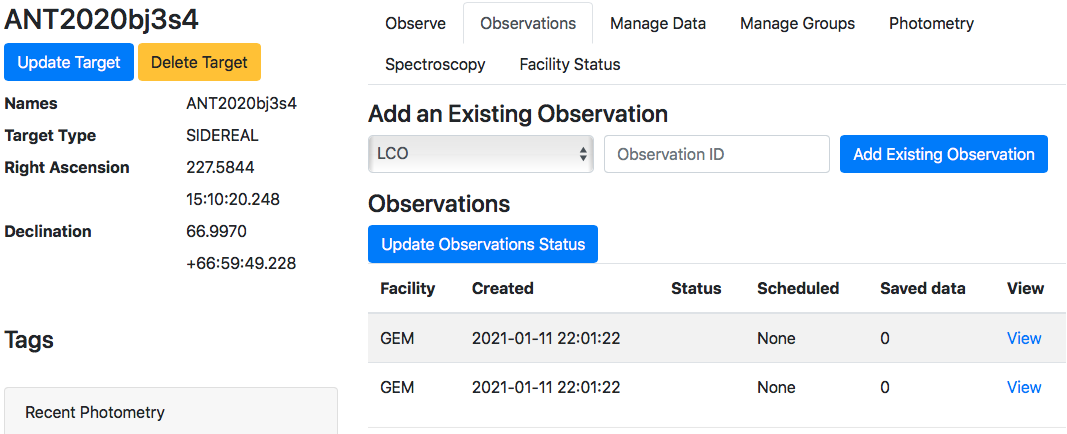

We can also see the new observations in the Gemini OT, ready to be observed:

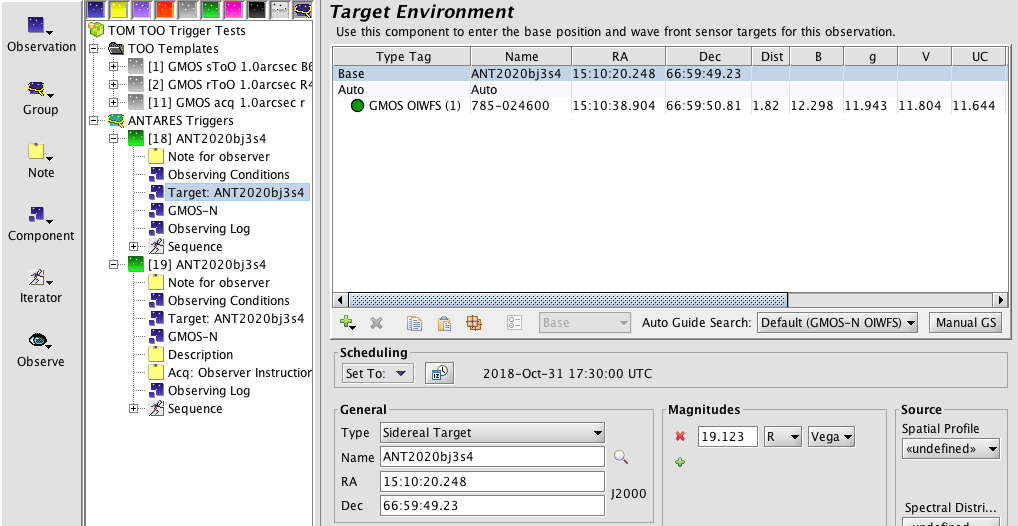

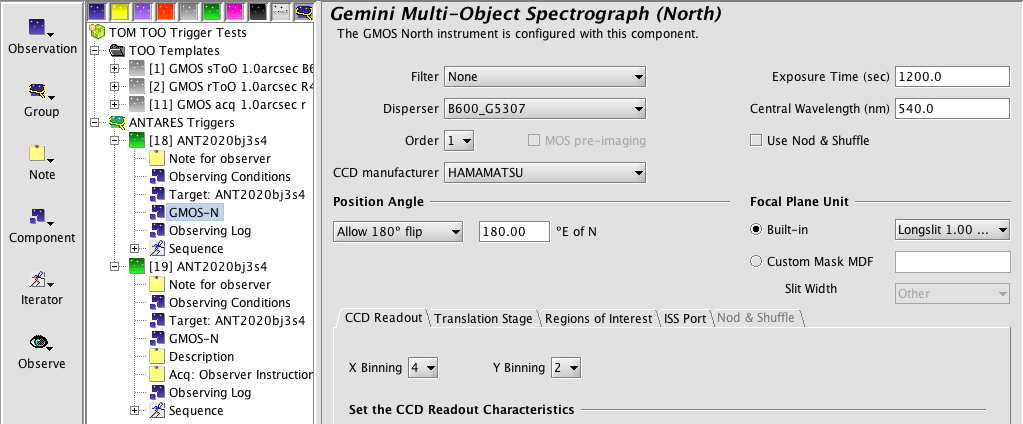